In [53]:
import glob
import numpy as np
import fitsio
import tqdm
import proplot as pplt
from mattspy.stats import mad

%matplotlib inline

In [5]:
fnames = glob.glob("y6a2_coadd_input_image_table_*.fits")
cdd = np.concatenate([fitsio.read(fname, lower=True) for fname in tqdm.tqdm(fnames, ncols=80)], axis=0)


100%|█████████████████████████████████████████████| 6/6 [00:38<00:00,  6.39s/it]


In [7]:
cdd = cdd[cdd["band"] == "r"]

In [54]:
import scipy.ndimage

dtype = [
    ("mjd_obs", "f8"),
    ("mag_zero", "f8"),
    ("mag_zero_std", "f8"),
]

night = (cdd["mjd_obs"] + 0.5).astype(int)
low_night = np.min(night)
revind = scipy.ndimage.value_indices(night - low_night)
d = np.zeros(len(revind), dtype=dtype)

for ind, (k, v) in enumerate(revind.items()):
    d["mjd_obs"][ind] = k
    d["mag_zero"][ind] = np.median(cdd["mag_zero"][v])
    d["mag_zero_std"][ind] = mad(cdd["mag_zero"][v])

In [122]:
from scipy.optimize import curve_fit


msk = d["mjd_obs"] < 600

x0 = d["mjd_obs"][msk]
y0 = d["mag_zero"][msk] - np.median(d["mag_zero"])

def func(x0, b, m):
    return b + m*x0

p0, cov0 = curve_fit(func, x0, y0, [0.1, 1e-3], absolute_sigma=True, sigma=d["mag_zero_std"][msk])
p0

array([ 0.07210155, -0.00015129])

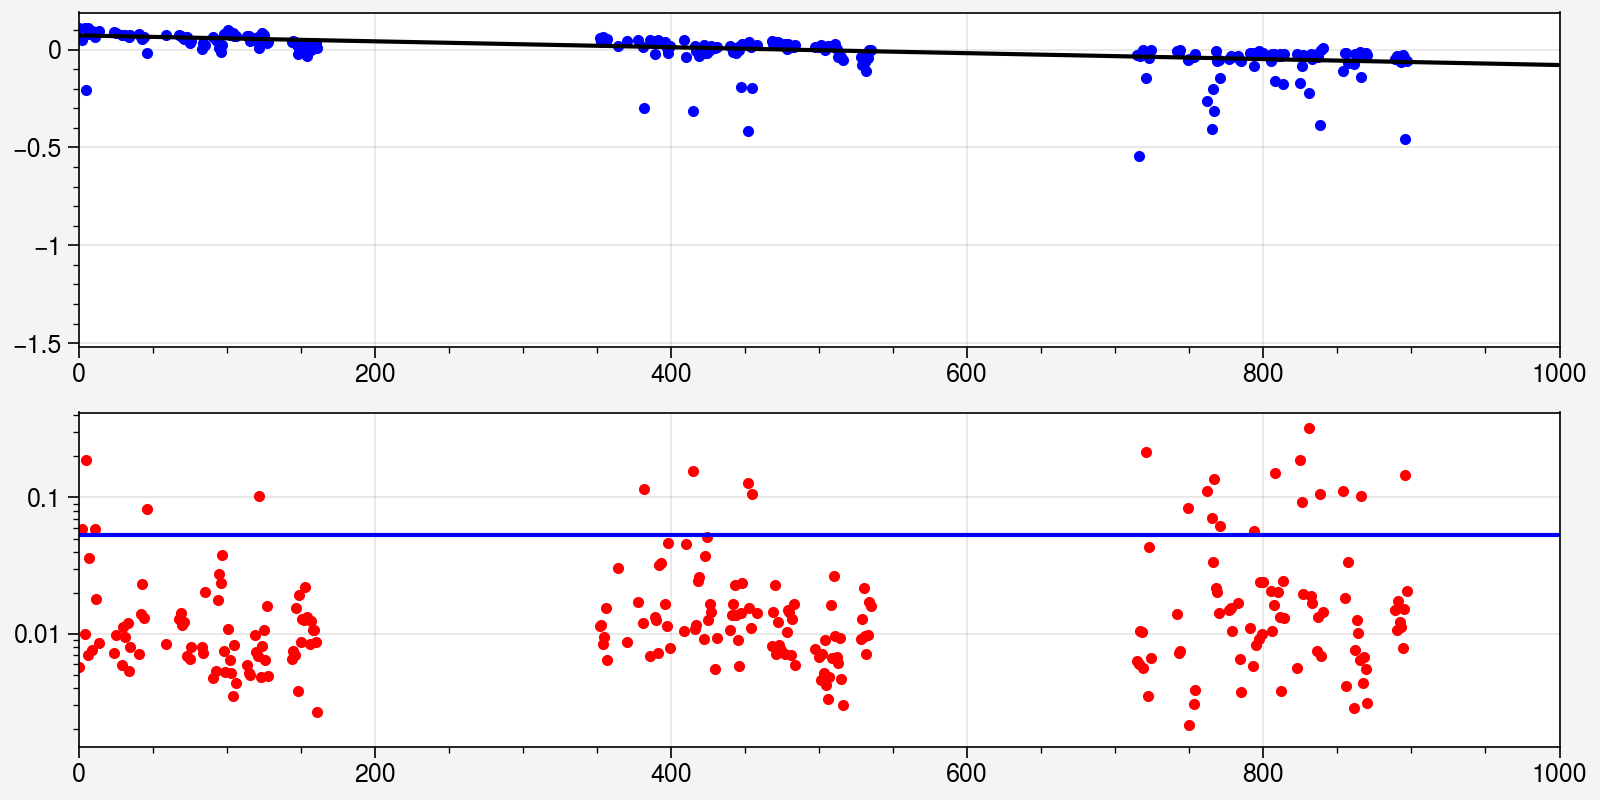

In [88]:
fig, axs = pplt.subplots(nrows=2, ncols=1, figsize=(8, 4), share=2)
yval = d["mag_zero"] - np.mean(d["mag_zero"])
axs[0, 0].plot(d["mjd_obs"], d["mag_zero"] - np.median(d["mag_zero"]), ".", color="b")
axs[0, 0].plot(np.linspace(0, 10000, 1000), func(np.linspace(0, 10000, 1000), *p0), color="k")
axs[1, 0].semilogy(d["mjd_obs"], d["mag_zero_std"], ".", color="r")
axs[1, 0].axhline(mad(d["mag_zero"]), color="b")

axs[1, 0].format(xlim=(0, 1000))
# axs.fill_between(d["mjd_obs"], yval -d["mag_zero_std"], yval + d["mag_zero_std"], color="k", alpha=0.25)
# axs.format(xlim=(56500, 56750))

0.04851151084899902

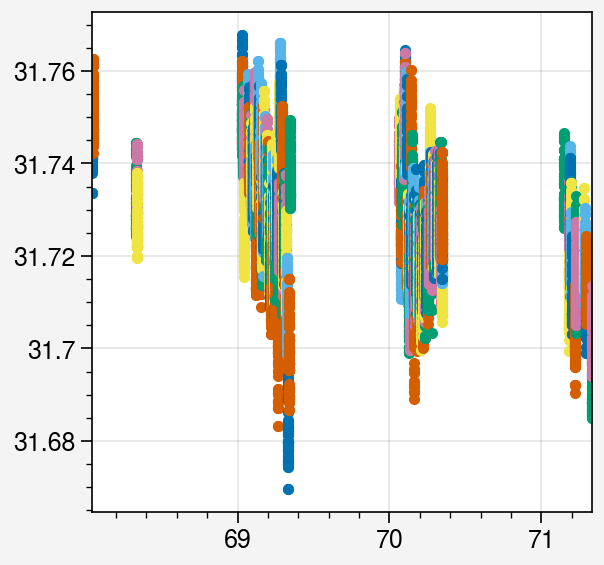

In [112]:
night = (cdd["mjd_obs"] + 0.5).astype(int)
ngt = night - np.min(night)
mngt = 72
lngt = 68
msk = (ngt >= lngt) & (ngt <= mngt)

fig, axs = pplt.subplots()

uexps = np.unique(cdd["expnum"][msk])
for uexp in uexps:
    msk = (ngt >= lngt) & (ngt <= mngt) & (cdd["expnum"] == uexp)

    axs[0, 0].plot(cdd["mjd_obs"][msk]-low_night, cdd["mag_zero"][msk], ".")

mad(cdd["mag_zero"])

In [114]:
msk = d["mjd_obs"] < 1000
mad(d["mag_zero"][msk] - func(d["mjd_obs"][msk], *p0))

0.030879067348510193

In [115]:
np.median(d["mag_zero"]), mad(d["mag_zero"]), np.median(d["mag_zero_std"])

(31.660823822021484, 0.05308412017822265, 0.010564791870117187)

In [116]:
dmz = d["mag_zero"][msk] - func(d["mjd_obs"][msk], *p0)

tot_var = mad(dmz)**2 + np.median(d["mag_zero_std"][msk])**2
np.sqrt(tot_var)

0.0327196269612751

In [118]:
mad(dmz)**2 / tot_var

0.8906594131463785